# Data Load

In [49]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset, Subset
import random
import numpy as np
import matplotlib.pyplot as plt

# Combine Datasets

In [50]:
def split_data(data, train_ratio = 0.8, valid_ratio = 0.1):
    random.seed = 1773
    total_data_len = len(data)
    indices = list(range(total_data_len))
    random.shuffle(indices)

    train_size = int(train_ratio * total_data_len)
    valid_size = int(valid_ratio * total_data_len)
    test_size = total_data_len - train_size - valid_size


    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:]
    
    train_dataset = Subset(data, train_indices)
    valid_dataset = Subset(data, valid_indices)
    test_dataset = Subset(data, test_indices)
    
    return train_dataset, valid_dataset, test_dataset

In [51]:
transform_image = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [64]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, transform = transform_image, mask_prob = 0.7):
        self.dataset = dataset
        self.transform = transform
        self.mask_prob = mask_prob
        
    def __len__(self):
        return(len(self.dataset))
    
    def __getitem__(self, index):
        image = self.dataset[index][0]

        if self.transform:
            image = self.transform(image)

        masked_image = self.create_mask(image)

        return image, masked_image

        
    def create_mask(self, image):
        masked_image = image.clone()
        random.seed = 1773
        mask_size_h = random.randint(image.shape[1]/4, image.shape[1]/2)
        mask_size_w = random.randint(image.shape[1]/4, image.shape[1]/2)
        
        if random.random() < self.mask_prob:
            mask_position_h = random.randint(0, image.shape[1] - mask_size_h)
            mask_position_w = random.randint(0, image.shape[2] - mask_size_w)
            masked_image[:, mask_position_h: mask_position_h + mask_size_h, 
                         mask_position_w: mask_position_w + mask_size_w] = 0
        
        return masked_image
    


In [65]:
dataset1 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\celeba",
)

dataset2 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\places",
)
random.seed = 1773
custom_data1 = Custom_Dataset(dataset1, transform=transform_image)
custom_data2 = Custom_Dataset(dataset2, transform=transform_image)

combined_dataset = ConcatDataset([custom_data1, custom_data2])


train_dataset, valid_dataset, test_dataset = split_data(combined_dataset)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


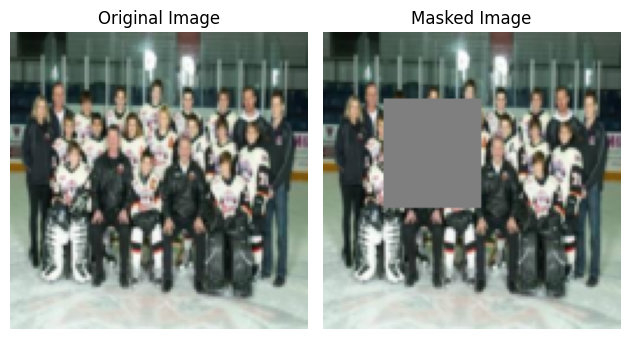

In [66]:
def unnormalize_and_convert(image):
    image = image.permute(1, 2, 0).cpu().numpy()  
    image = (image * 0.5) + 0.5  
    image = np.clip(image, 0, 1)  
    return image

original_image, masked_image = train_dataset[random.randint(0,2000)]  

plt.figure()

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(unnormalize_and_convert(original_image))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(unnormalize_and_convert(masked_image))
plt.axis('off')

plt.tight_layout()
plt.show()


# Transformer